In [139]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from timeit import default_timer as timer

In [140]:
# get the data
df_damri = pd.read_csv("../data/damri_apps_preprocessed.csv")
df_damri['cleaned_text'].fillna('', inplace=True)
df_damri.head()



,content,cleaned_text,tokenized_raw_text,tokenized_preprocessed_text,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,bug/ keamanan ? aplikasi lama ga di buka ketik...,bug aman aplikasi lama tidak buka mau buka sel...,"['bug', 'keamanan', 'aplikasi', 'lama', 'ga', ...","['bug', 'aman', 'aplikasi', 'lama', 'tidak', '...",2,0,4.5.4,2025-09-19 20:37:03,NaN,NaN
1,Armada sangat sedikit butuh waktu yg lama untu...,armada sangat sedikit butuh waktu lama tunggu ...,"['armada', 'sangat', 'sedikit', 'butuh', 'wakt...","['armada', 'sangat', 'sedikit', 'butuh', 'wakt...",2,0,NaN,2025-09-18 19:32:01,NaN,NaN
2,"sangat membantu,,bisa pilih kursi tanpa harus ...",sangat bantu bisa pilih kursi harus pergi loket,"['sangat', 'membantubisa', 'pilih', 'kursi', '...","['sangat', 'membantubisa', 'pilih', 'kursi', '...",5,0,NaN,2025-09-16 17:30:00,NaN,NaN
3,Pelayanannya baik,layan baik,"['pelayanannya', 'baik']","['layan', 'baik']",5,0,NaN,2025-09-16 15:38:28,NaN,NaN
4,sangat membantu,sangat bantu,"['sangat', 'membantu']","['sangat', 'bantu']",5,0,4.5.4,2025-09-15 15:31:35,NaN,NaN


In [141]:
# get sentiment
df_damri['sentiment'] = df_damri['score'].apply(lambda x : 1 if x >= 4 else 0)
df_damri.head()

,content,cleaned_text,tokenized_raw_text,tokenized_preprocessed_text,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sentiment
0,bug/ keamanan ? aplikasi lama ga di buka ketik...,bug aman aplikasi lama tidak buka mau buka sel...,"['bug', 'keamanan', 'aplikasi', 'lama', 'ga', ...","['bug', 'aman', 'aplikasi', 'lama', 'tidak', '...",2,0,4.5.4,2025-09-19 20:37:03,NaN,NaN,0
1,Armada sangat sedikit butuh waktu yg lama untu...,armada sangat sedikit butuh waktu lama tunggu ...,"['armada', 'sangat', 'sedikit', 'butuh', 'wakt...","['armada', 'sangat', 'sedikit', 'butuh', 'wakt...",2,0,NaN,2025-09-18 19:32:01,NaN,NaN,0
2,"sangat membantu,,bisa pilih kursi tanpa harus ...",sangat bantu bisa pilih kursi harus pergi loket,"['sangat', 'membantubisa', 'pilih', 'kursi', '...","['sangat', 'membantubisa', 'pilih', 'kursi', '...",5,0,NaN,2025-09-16 17:30:00,NaN,NaN,1
3,Pelayanannya baik,layan baik,"['pelayanannya', 'baik']","['layan', 'baik']",5,0,NaN,2025-09-16 15:38:28,NaN,NaN,1
4,sangat membantu,sangat bantu,"['sangat', 'membantu']","['sangat', 'bantu']",5,0,4.5.4,2025-09-15 15:31:35,NaN,NaN,1


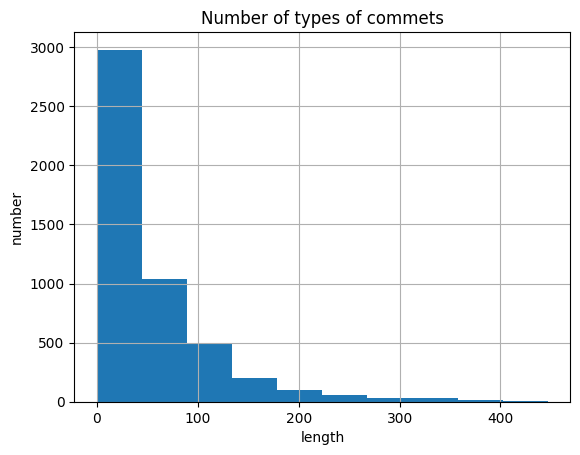

count    4945.000000
mean       53.855005
std        61.599134
min         0.000000
25%        12.000000
50%        33.000000
75%        72.000000
max       447.000000
dtype: float64


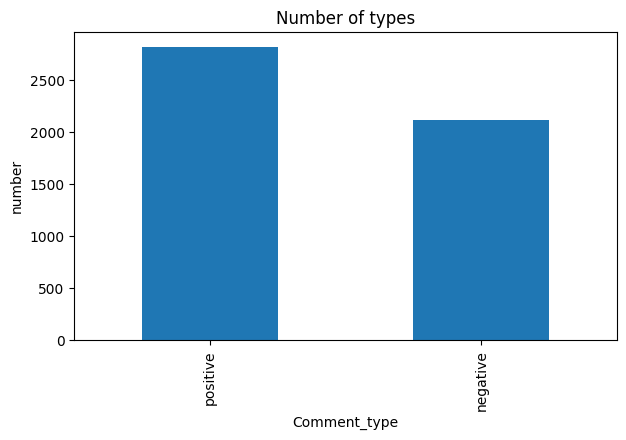

In [142]:
# Simple EDA
class EDA():
    def get_length_dist(self,data):
        rev_len = [len(i) for i in data]
        pd.Series(rev_len).hist()
        plt.title('Number of types of commets')
        plt.xlabel('length')
        plt.ylabel('number')
        plt.show()
        print(pd.Series(rev_len).describe())
    def get_class_dist(self,df):
        df['sentiment'].replace({1:'positive',0:'negative'}).value_counts().plot(kind='bar',figsize=(7,4))
        plt.title('Number of types')
        plt.xlabel('Comment_type')
        plt.ylabel('number')
        plt.show()

eda = EDA()
eda.get_length_dist(df_damri['cleaned_text'])
eda.get_class_dist(df_damri)

### Split the data

In [143]:
x = df_damri['cleaned_text']
Y = df_damri['sentiment']

In [144]:
xtrain, xtest, ytrain, ytest = train_test_split(x, Y, test_size=0.2, random_state=42)

### Display words count

In [145]:

from collections import Counter
word_counts = Counter(' '.join(xtrain).split())
vocab = [word for word, count in word_counts.most_common()]
vocab[0:10]

['tidak',
 'aplikasi',
 'damri',
 'tiket',
 'sangat',
 'bantu',
 'mudah',
 'baik',
 'mau',
 'bagus']

### TF-IDF Vectorization

In [146]:
batch_size = 1000

In [147]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

In [148]:
start = timer()
X_train_tfidf = tfidf_vectorizer.fit_transform(xtrain)
X_test_tfidf = tfidf_vectorizer.transform(xtest)
print("TF-IDF Vectorization Time:", timer() - start)

TF-IDF Vectorization Time: 0.04454502299995511


In [149]:
# Vectorize train data
start = timer()
tfidf_vectorizer_xtrain = []
for i in range(0, len(xtrain), batch_size):
    batch_X_train = xtrain[i:i + batch_size]
    batch_X_train_tfidf = tfidf_vectorizer.fit_transform(batch_X_train)
    tfidf_vectorizer_xtrain.extend(batch_X_train_tfidf.toarray())
print('Required time for embedding TFIDF with train data:- ', timer() - start)

Required time for embedding TFIDF with train data:-  0.0741077340026095


In [150]:
# Vectorize test data
start = timer()
tfidf_vectorizer_xtest = []
for i in range(0, len(xtest), batch_size):
    batch_X_test = xtest[i:i + batch_size]
    batch_X_test_tfidf = tfidf_vectorizer.transform(batch_X_test)
    tfidf_vectorizer_xtest.extend(batch_X_test_tfidf.toarray())
print('Required time for embedding TFIDF with train data:- ', timer() - start)

Required time for embedding TFIDF with train data:-  0.01785061900227447


In [151]:
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1 Score: {f1:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return acc

### Linear SVM Classification

In [152]:
svm_classifier = LinearSVC()

In [153]:
start = timer()
svm_tfidf = svm_classifier.fit(X_train_tfidf, ytrain)
print('Required time for training Linear SVM classifiers:- ', timer() - start)

Required time for training Linear SVM classifiers:-  0.011648477000562707


In [154]:
acc_svm = evaluate_model(svm_tfidf, X_test_tfidf, ytest, "Linear SVM")


Linear SVM Results:
Accuracy: 0.8827 | Precision: 0.8908 | Recall: 0.9036 | F1 Score: 0.8972
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86       429
           1       0.89      0.90      0.90       560

    accuracy                           0.88       989
   macro avg       0.88      0.88      0.88       989
weighted avg       0.88      0.88      0.88       989



### Logistic Regression Classification

In [155]:
lr_classifier = LogisticRegression(max_iter=1000)

In [156]:
start = timer()
lr_tfidf = lr_classifier.fit(X_train_tfidf, ytrain)
print('Required time for training Logistic Regression classifiers:- ', timer() - start)

Required time for training Logistic Regression classifiers:-  0.028331371999229304


In [157]:
acc_lr = evaluate_model(lr_tfidf, X_test_tfidf, ytest, "Logistic Regression")


Logistic Regression Results:
Accuracy: 0.8878 | Precision: 0.9002 | Recall: 0.9018 | F1 Score: 0.9010
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87       429
           1       0.90      0.90      0.90       560

    accuracy                           0.89       989
   macro avg       0.89      0.89      0.89       989
weighted avg       0.89      0.89      0.89       989



### Multinomial Naive Bayes Classification

In [158]:
mnb_classifier = MultinomialNB()

In [159]:
start = timer()
mnb_tfidf = mnb_classifier.fit(X_train_tfidf, ytrain)
print('Required time for training Multinomial Naive bayes classifiers:- ', timer() - start)

Required time for training Multinomial Naive bayes classifiers:-  0.0038685639992763754


In [160]:
acc_mnb = evaluate_model(mnb_tfidf, X_test_tfidf, ytest, "Multinomial Naive Bayes")


Multinomial Naive Bayes Results:
Accuracy: 0.8948 | Precision: 0.9161 | Recall: 0.8964 | F1 Score: 0.9061
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88       429
           1       0.92      0.90      0.91       560

    accuracy                           0.89       989
   macro avg       0.89      0.89      0.89       989
weighted avg       0.90      0.89      0.89       989



### XGBoost Classification

In [161]:
xgb_classifier = XGBClassifier(eval_metric='logloss')

In [162]:
start = timer()
xgb_tfidf = xgb_classifier.fit(X_train_tfidf, ytrain)
print('Required time for training XGBoost classifiers:- ', timer() - start)

Required time for training XGBoost classifiers:-  1.494073584999569


In [163]:
acc_xgb = evaluate_model(xgb_tfidf, X_test_tfidf, ytest, "XGBoost")


XGBoost Results:
Accuracy: 0.8655 | Precision: 0.8675 | Recall: 0.9000 | F1 Score: 0.8834
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84       429
           1       0.87      0.90      0.88       560

    accuracy                           0.87       989
   macro avg       0.87      0.86      0.86       989
weighted avg       0.87      0.87      0.87       989



### Random Forest Classification

In [164]:
rf_classifier = RandomForestClassifier(n_estimators=150, max_depth=35, max_features='sqrt', min_samples_leaf=4, bootstrap=True, n_jobs=-1)

In [165]:
start = timer()
rf_tfidf = rf_classifier.fit(X_train_tfidf, ytrain)
print('Required time for training Random Forest classifiers:- ', timer() - start)

Required time for training Random Forest classifiers:-  0.3513221290013462


In [166]:
acc_rf = evaluate_model(rf_tfidf, X_test_tfidf, ytest, "Random Forest")


Random Forest Results:
Accuracy: 0.8574 | Precision: 0.8451 | Recall: 0.9161 | F1 Score: 0.8792
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.83       429
           1       0.85      0.92      0.88       560

    accuracy                           0.86       989
   macro avg       0.86      0.85      0.85       989
weighted avg       0.86      0.86      0.86       989



### Model Comparison

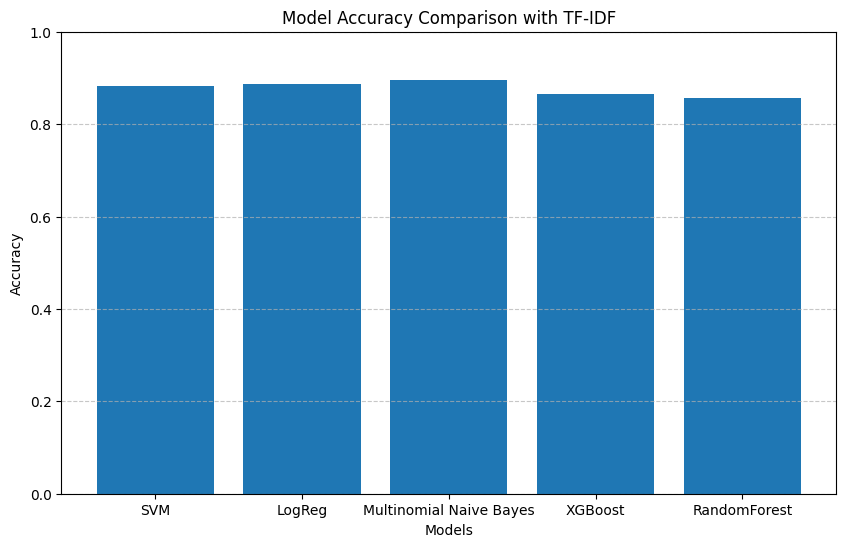

In [167]:
model_names = ['SVM', 'LogReg', 'Multinomial Naive Bayes', 'XGBoost', 'RandomForest']
accuracies = [acc_svm, acc_lr, acc_mnb, acc_xgb, acc_rf]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison with TF-IDF")
plt.ylim(0.0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()